In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import mapply
mapply.init(n_workers=7, progressbar=True)

import pickle
with open('scaler.pickle', 'rb') as f:
    scaler: StandardScaler = pickle.load(f)

# Read in the data
final = pd.read_csv('../dataset/data/final_clean3.csv')

final.columns






/home/stefano/Desktop/Big Data Unipi/DM/Project/DataMining-2023/.env9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Index(['date_year', 'date_month', 'state', 'incident_characteristics1',
       'congressional_district', 'date_day', 'city_or_county', 'latitude',
       'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants', 'CLEAN', 'timestamp',
       'povertyPercentage', 'party', 'candidatevotes', 'totalvotes',
       'state_population', 'OUTLIER', 'p_males', 'p_females',
       'p_participants_child', 'p_participants_teen', 'p_participants_adult',
       'p_killed', 'p_injured', 'p_arrested', 'p_unharmed',
       'month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants',
       'month_state_change_min_age_participants',
       'month_state_change_avg_age_participants',
       'month_state_change_max_age_partici

In [2]:
final.shape

final.head()

,date_year,date_month,state,incident_characteristics1,congressional_district,date_day,city_or_county,latitude,longitude,min_age_participants,...,cd_month_SHOT_DEAD,cd_month_NON_SHOOTING,cd_month_SHOTS_FIRED_UNHARMED,cd_month_OTHER,state_month_SHOT_INJURED,state_month_SHOT_DEAD,state_month_NON_SHOOTING,state_month_SHOTS_FIRED_UNHARMED,state_month_OTHER,non_workday
0,2013.0,1,CALIFORNIA,SHOT_INJURED,43.0,1,Hawthorne,33.9090,-118.3330,20.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
1,2013.0,1,COLORADO,SHOT_DEAD,6.0,5,Aurora,39.6518,-104.8020,29.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,2013.0,1,LOUISIANA,SHOT_INJURED,2.0,21,New Orleans,29.9435,-90.0836,16.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
3,2013.0,1,LOUISIANA,SHOT_INJURED,3.0,26,Charenton,29.8816,-91.5251,48.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,2013.0,1,MARYLAND,SHOT_INJURED,7.0,23,Baltimore,39.2899,-76.6412,15.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [5]:
#filter only for accidents  between 2014 and 2017
final_wout_wrng_years = final[(final['date_year'] >= 2014) & (final['date_year'] <= 2017)].copy()


## Dataframe with only the correct years for timeseries
final_wout_wrng_years.shape

final_wout_wrng_years.columns

# make a new column with the week number from timestamp//7 - number of weeks from 2010-01-01

final_wout_wrng_years['week_number'] = (final_wout_wrng_years['timestamp']//7) - 208

final_wout_wrng_years['week_number'] = final_wout_wrng_years['week_number'].astype(int)




In [6]:
#sort by week using date_year, date_month, date_day
city_df = final_wout_wrng_years.sort_values(by=['week_number']).copy()
city_df

#boston = city_df[city_df['city_or_county'] == 'Boston'].copy()



#create a new dataframe with 3 colums: week_number, city, number of accidents per week

cool_df = city_df.groupby(['week_number', 'city_or_county']).size().reset_index(name='counts')
#cool_df

#pivot the table to have the cities as columns
pivot_df = cool_df.pivot(index='week_number', columns='city_or_county', values='counts')
#pivot_df

#fill the NaN values with 0
pivot_df = pivot_df.fillna(0)
pivot_df

#make them integers
pivot_df = pivot_df.astype(int)
pivot_df




city_or_county,Abbeville,Abbotsford,Abbott,Abbott Township,Abbottstown,Abercrombie,Aberdeen,Abilene,Abingdon,Abington,...,Zion,Zion (Beach Park),Zion Grove,Zionsville,Zionville,Zumbro Falls,Zumbrota,Zuni (Zuni Pueblo),Zwolle,jefferson parish (county)
week_number,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
205,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#remove the colums with less than 15% of 208 weeks
pivot_df = pivot_df.loc[:, (pivot_df.sum(axis=0) > 30)]
pivot_df

#give me the list of cities remaining
pivot_df.columns



final_pivot = pivot_df.copy()

#remove from city_df the cities that are not in the pivot_df
clean_city_df = city_df[city_df['city_or_county'].isin(final_pivot.columns)].copy()

clean_city_df.columns


Index(['date_year', 'date_month', 'state', 'incident_characteristics1',
       'congressional_district', 'date_day', 'city_or_county', 'latitude',
       'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants', 'CLEAN', 'timestamp',
       'povertyPercentage', 'party', 'candidatevotes', 'totalvotes',
       'state_population', 'OUTLIER', 'p_males', 'p_females',
       'p_participants_child', 'p_participants_teen', 'p_participants_adult',
       'p_killed', 'p_injured', 'p_arrested', 'p_unharmed',
       'month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants',
       'month_state_change_min_age_participants',
       'month_state_change_avg_age_participants',
       'month_state_change_max_age_partici

In [22]:
clean_city_df.groupby(['city_or_county'])["n_killed"].sum().sort_values(ascending=True)


city_or_county
Oil City (Caddo)       1.0
Meriden                1.0
Janesville             2.0
Fulton                 2.0
Framingham             2.0
                     ...  
Philadelphia         877.0
Saint Louis          904.0
Baltimore           1042.0
Houston             1169.0
Chicago             2093.0
Name: n_killed, Length: 790, dtype: float64

## Score for each city

In [19]:
TO_RENAME = clean_city_df.copy()

TO_RENAME = TO_RENAME.set_index(['week_number','city_or_county'])

def score(df: pd.DataFrame):
    return df['n_killed'].sum() + df['n_injured'].sum() * 0.8 + df['n_arrested'].sum() * 0.5 + df['n_participants_child'].sum() * 1 + df['n_participants_teen'].sum() * 0.8 + df['n_participants_adult'].sum() * 0.5
    #return df['n_killed'].sum()


TO_RENAME['score'] = TO_RENAME.groupby(TO_RENAME.index.names).apply(score)


score_pivot = TO_RENAME.pivot_table(index='week_number', columns='city_or_county', values='score')
score_pivot = score_pivot.fillna(0)






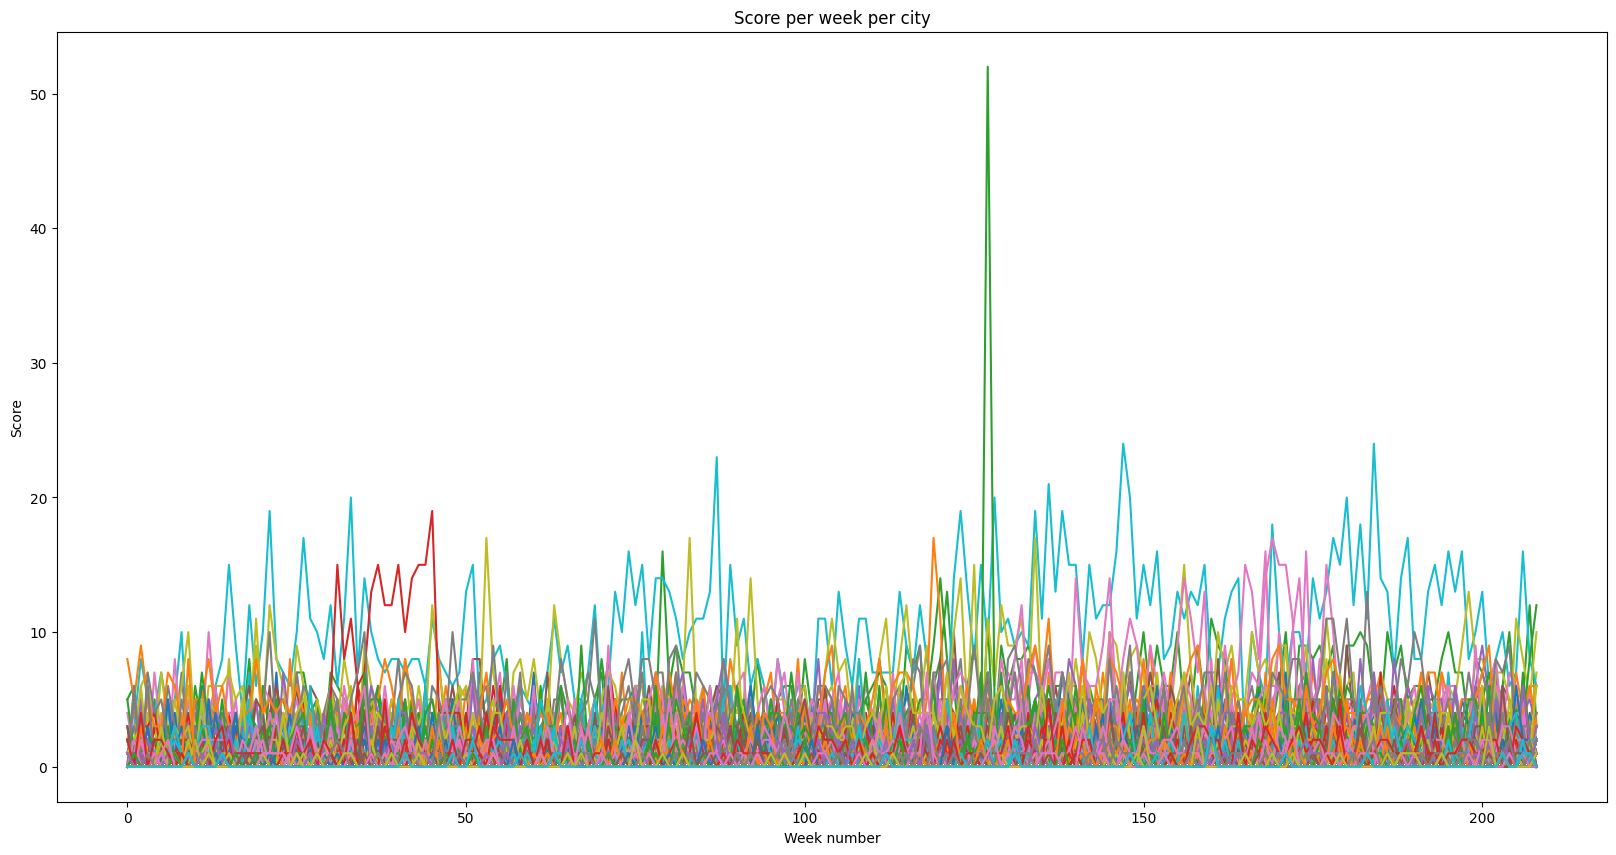

In [20]:
#plot the timeseries with a bigger figure size but without the legend

score_pivot.plot(figsize=(20,10), legend=False)
plt.title('Score per week per city')
plt.xlabel('Week number')
plt.ylabel('Score')
plt.show()




In [ ]:
#show the number of timeseries with score == 0
score_pivot[score_pivot == 0].count(axis=1).plot(figsize=(20,10))

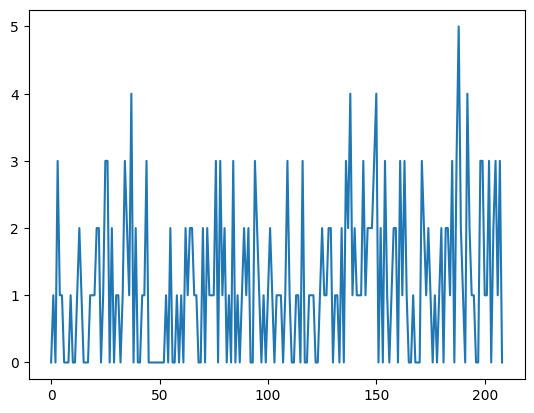

In [8]:
ts1 = pd.Series(score_pivot['Boston'])
plt.plot(ts1)
plt.show()

---

## Distances between time series 

<Axes: xlabel='week_number'>

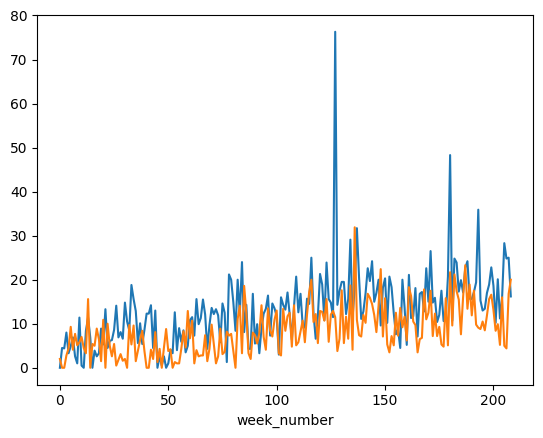

In [12]:
#create a dict containing the cities and the time series for the city
ts_dict = {}
for city in score_pivot.columns:
    ts_dict[city] = pd.Series(score_pivot[city])

ts_dict['Boston'].plot()
ts_dict['Birmingham'].plot()

   

    


In [13]:
#scaler mean variance
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

#------------------------------------------------------------------------------------------
#scaled with mean variance

scaler_mean = TimeSeriesScalerMeanVariance(mu=0, std=1)  

#scale all the time series
scaled_mean_ts_dict = {}
for city in ts_dict.keys():
    scaled_mean_ts_dict[city] = scaler_mean.fit_transform(ts_dict[city].values.reshape(1, -1)).flatten()

#plt.plot(scaled_mean_ts_dict['Boston'])
#plt.plot(scaled_mean_ts_dict['Birmingham'])


#------------------------------------------------------------------------------------------
#scaled with min max

from tslearn.preprocessing import TimeSeriesScalerMinMax

scaler_minmax = TimeSeriesScalerMinMax(value_range=(0, 1))

#scale all the time series
scaled_minmax_ts_dict = {}
for city in ts_dict.keys():
    scaled_minmax_ts_dict[city] = scaler_minmax.fit_transform(ts_dict[city].values.reshape(1, -1)).flatten()

# plt.plot(scaled_minmax_ts_dict['Boston'])
# plt.plot(scaled_minmax_ts_dict['Birmingham'])





In [11]:
from scipy.spatial.distance import euclidean, cityblock

#make the euclidean distance matrix
euclidean_matrix = np.zeros((len(ts_dict), len(ts_dict)))
for i, city1 in enumerate(ts_dict.keys()):
    for j, city2 in enumerate(ts_dict.keys()):
        euclidean_matrix[i, j] = euclidean(ts_dict[city1], ts_dict[city2])



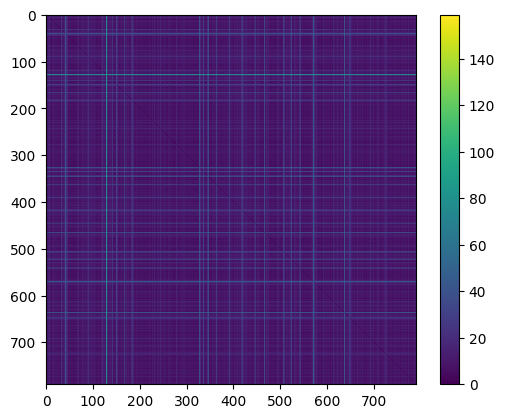

In [12]:
#plot the euclidean distance matrix
plt.imshow(euclidean_matrix)
plt.colorbar()
plt.show()



In [13]:
#make the cityblock distance matrix
cityblock_matrix = np.zeros((len(ts_dict), len(ts_dict)))
for i, city1 in enumerate(ts_dict.keys()):
    for j, city2 in enumerate(ts_dict.keys()):
        cityblock_matrix[i, j] = cityblock(ts_dict[city1], ts_dict[city2])

    

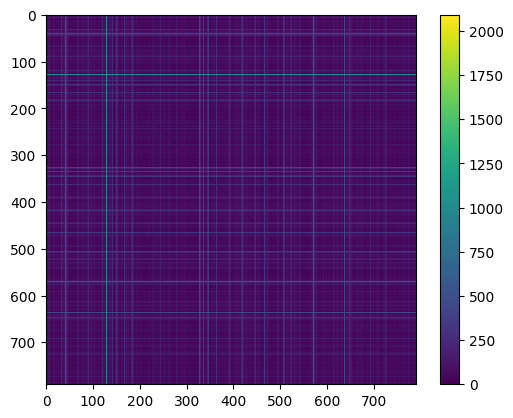

In [14]:
#plot the cityblock distance matrix
plt.imshow(cityblock_matrix)
plt.colorbar()
plt.show()


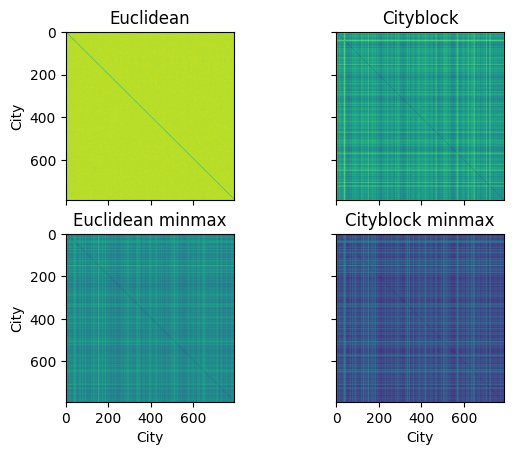

In [15]:
#make the euclidean distance matrix with the scaled time series
euclidean_matrix_scaled = np.zeros((len(ts_dict), len(ts_dict)))
for i, city1 in enumerate(scaled_mean_ts_dict.keys()):
    for j, city2 in enumerate(scaled_mean_ts_dict.keys()):
        euclidean_matrix_scaled[i, j] = euclidean(scaled_mean_ts_dict[city1], scaled_mean_ts_dict[city2])

#make the cityblock distance matrix with the scaled time series
cityblock_matrix_scaled = np.zeros((len(ts_dict), len(ts_dict)))
for i, city1 in enumerate(scaled_mean_ts_dict.keys()):
    for j, city2 in enumerate(scaled_mean_ts_dict.keys()):
        cityblock_matrix_scaled[i, j] = cityblock(scaled_mean_ts_dict[city1], scaled_mean_ts_dict[city2])


#make the euclidean distance matrix with the scaled time series
euclidean_matrix_scaled_minmax = np.zeros((len(ts_dict), len(ts_dict)))
for i, city1 in enumerate(scaled_minmax_ts_dict.keys()):
    for j, city2 in enumerate(scaled_minmax_ts_dict.keys()):
        euclidean_matrix_scaled_minmax[i, j] = euclidean(scaled_minmax_ts_dict[city1], scaled_minmax_ts_dict[city2])

#make the cityblock distance matrix with the scaled time series
cityblock_matrix_scaled_minmax = np.zeros((len(ts_dict), len(ts_dict)))
for i, city1 in enumerate(scaled_minmax_ts_dict.keys()):
    for j, city2 in enumerate(scaled_minmax_ts_dict.keys()):
        cityblock_matrix_scaled_minmax[i, j] = cityblock(scaled_minmax_ts_dict[city1], scaled_minmax_ts_dict[city2])

#plot all the distance matrices with labels
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(euclidean_matrix_scaled)
axs[0, 0].set_title('Euclidean')
axs[0, 1].imshow(cityblock_matrix_scaled)
axs[0, 1].set_title('Cityblock')
axs[1, 0].imshow(euclidean_matrix_scaled_minmax)
axs[1, 0].set_title('Euclidean minmax')
axs[1, 1].imshow(cityblock_matrix_scaled_minmax)
axs[1, 1].set_title('Cityblock minmax')
for ax in axs.flat:
    ax.set(xlabel='City', ylabel='City')
for ax in axs.flat:
    ax.label_outer()
plt.show()



In [16]:
from tslearn.metrics import dtw, dtw_path, cdist_dtw, subsequence_cost_matrix

dist = dtw(ts_dict['Boston'], ts_dict['Birmingham'])

path, dist = dtw_path(ts_dict['Boston'], ts_dict['Birmingham'])
dist



14.52583904633395

In [17]:
path


[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 1),
 (7, 1),
 (8, 2),
 (9, 3),
 (10, 4),
 (11, 4),
 (12, 5),
 (13, 5),
 (14, 5),
 (15, 6),
 (16, 6),
 (17, 7),
 (18, 8),
 (19, 8),
 (20, 8),
 (21, 9),
 (21, 10),
 (22, 11),
 (23, 12),
 (24, 12),
 (25, 13),
 (26, 13),
 (27, 14),
 (28, 15),
 (29, 15),
 (30, 15),
 (31, 15),
 (32, 15),
 (33, 16),
 (34, 17),
 (34, 18),
 (35, 19),
 (35, 20),
 (36, 21),
 (37, 22),
 (37, 23),
 (38, 24),
 (38, 25),
 (38, 26),
 (38, 27),
 (38, 28),
 (38, 29),
 (39, 30),
 (40, 31),
 (41, 31),
 (42, 32),
 (43, 33),
 (44, 34),
 (45, 35),
 (46, 35),
 (47, 35),
 (48, 35),
 (49, 35),
 (50, 35),
 (51, 35),
 (52, 35),
 (53, 36),
 (54, 37),
 (55, 38),
 (56, 39),
 (56, 40),
 (57, 41),
 (58, 42),
 (58, 43),
 (58, 44),
 (59, 45),
 (60, 46),
 (61, 47),
 (62, 48),
 (63, 48),
 (64, 48),
 (65, 49),
 (66, 50),
 (67, 50),
 (68, 51),
 (68, 52),
 (68, 53),
 (68, 54),
 (69, 55),
 (70, 56),
 (70, 57),
 (70, 58),
 (70, 59),
 (70, 60),
 (70, 61),
 (71, 62),
 (72, 63),
 (73, 64)

In [18]:
from scipy.spatial.distance import cdist

In [19]:

#we compute the path 
path, dist = dtw_path(ts_dict['Boston'][:10], ts_dict['Birmingham'][:10], global_constraint="sakoe_chiba", sakoe_chiba_radius=3)
dist

2.449489742783178

In [20]:
path


[(0, 0),
 (0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (3, 5),
 (4, 5),
 (5, 5),
 (6, 6),
 (7, 6),
 (8, 7),
 (9, 8),
 (9, 9)]

In [21]:
from scipy.spatial.distance import cdist

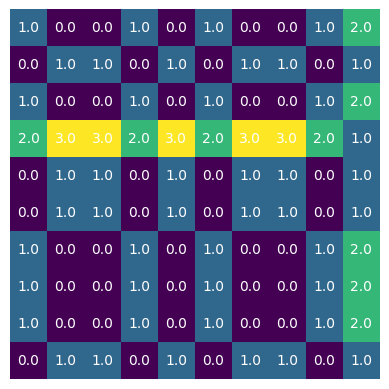

In [22]:
mat = cdist(ts_dict['Boston'].values[:10].reshape(-1,1), ts_dict['Birmingham'].values[:10].reshape(-1,1))

plt.imshow(mat)
plt.axis("off")
plt.autoscale(False)
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        text = plt.text(j, i, '%.1f' % mat[i, j], ha="center", va="center", color="w")
        
plt.show()

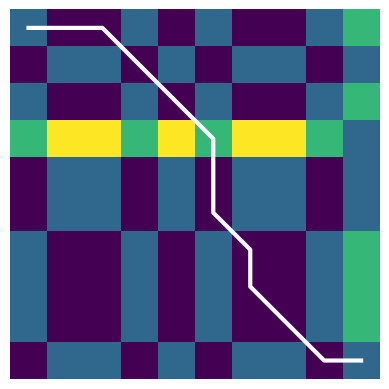

In [23]:
#we compute the distance (default euclidean)
mat = cdist(ts_dict['Boston'].values[:10].reshape(-1,1), ts_dict['Birmingham'].values[:10].reshape(-1,1))
plt.imshow(mat)
plt.axis("off")
plt.autoscale(False)
plt.plot([j for (i, j) in path], [i for (i, j) in path], "w-", linewidth=3.)
plt.show()

---

# CLUSTERING

In [14]:
#define a function to extract statistical features
import scipy.stats as stats
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [15]:
#calculate the features for each time series
features_dict = {}
for city in ts_dict.keys():
    features_dict[city] = calculate_features(ts_dict[city])

features_dict['Boston']

{'avg': 13.110526315789473,
 'std': 8.39755513580452,
 'var': 70.51893225887687,
 'med': 12.4,
 '10p': 3.98,
 '25p': 8.0,
 '50p': 12.4,
 '75p': 17.1,
 '90p': 21.220000000000002,
 'iqr': 9.100000000000001,
 'cov': 1.561231346953631,
 'skw': 2.4446630616494915,
 'kur': 15.039896808408475}

# ------------------------------------------------------------

# K-means clustering

In [16]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.generators import random_walks
import matplotlib.pyplot as plt
import numpy as np


 

In [17]:
#create an array with the time series
X_std = np.array(list(ts_dict.values()))
X_std.shape

(790, 209)

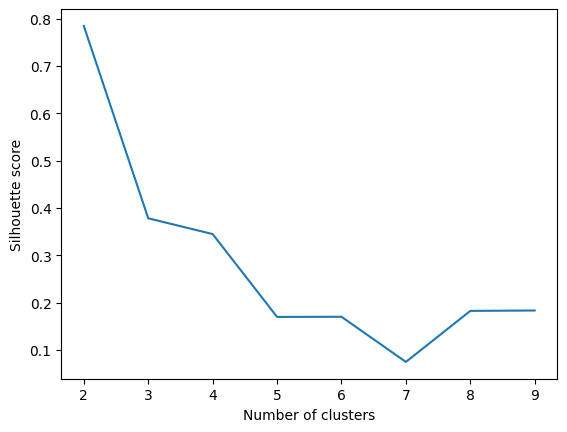

In [51]:


#calculate the silhouette score for different number of clusters
silhouette_scores = []
for n_clusters in range(2, 10):
    km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=5, random_state=0).fit(X_std)
    silhouette_scores.append(silhouette_score(X_std, km.labels_))

#plot the silhouette scores
plt.plot(range(2, 10), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


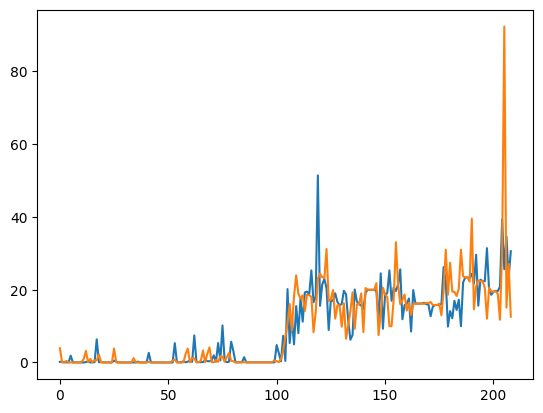

In [18]:

#kmeans clustering
km = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=5, random_state=0).fit(X_std)


plt.plot(km.cluster_centers_.reshape(X_std.shape[1], 2))
plt.show()


In [19]:
km.inertia_

1193.4292516043242

## Scaled K-means

### Minmax scaler K-means

In [30]:
#create an array with the time series
X_minmax = np.array(list(scaled_minmax_ts_dict.values()))
X_minmax.shape

(790, 209)

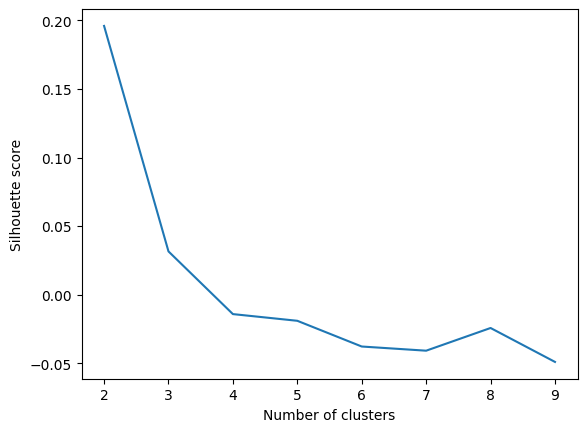

In [43]:


#calculate the silhouette score for different number of clusters
silhouette_scores = []
for n_clusters in range(2, 10):
    km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=5, random_state=0).fit(X_minmax)
    silhouette_scores.append(silhouette_score(X_minmax, km.labels_))

#plot the silhouette scores
plt.plot(range(2, 10), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


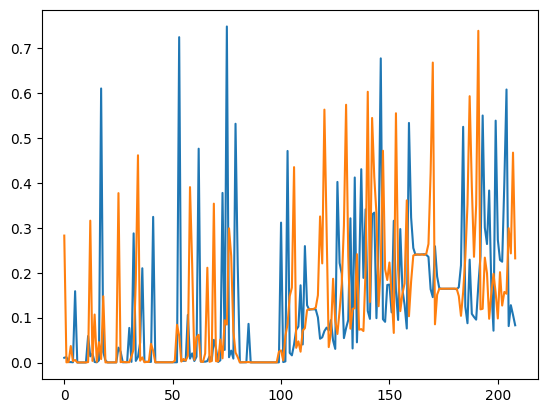

In [32]:

#kmeans clustering
km_minmax = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=5, random_state=0).fit(X_minmax)


plt.plot(km_minmax.cluster_centers_.reshape(X_minmax.shape[1], 2))
plt.show()


In [ ]:
km_minmax.inertia_

1.7776129474001527

### Standard scaler K-means

In [28]:
#create an array with the time series
X_mean = np.array(list(scaled_mean_ts_dict.values()))
X_mean.shape

(790, 209)

In [12]:


#calculate the silhouette score for different number of clusters
silhouette_scores = []
for n_clusters in range(2, 10):
    km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=5, random_state=0).fit(X_mean)
    silhouette_scores.append(silhouette_score(X_mean, km.labels_))

#plot the silhouette scores
plt.plot(range(2, 10), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


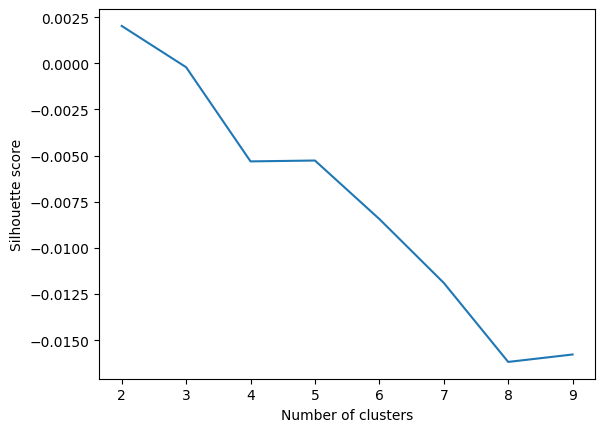

In [14]:
#plot the silhouette scores
plt.plot(range(2, 10), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [27]:

#create an array with the time series
X = np.array(list(scaled_mean_ts_dict.values()))
X.shape


(790, 209)

In [15]:




#kmeans clustering
km_mean = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=5, random_state=0).fit(X)


plt.plot(km_mean.cluster_centers_.reshape(X.shape[1], 2))
plt.show()


KeyboardInterrupt: 

In [48]:
km_mean.inertia_

55.21394436609463

# 2. Feature-based clustering 


In [24]:
import scipy.stats as stats
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

### Non scaled K-means

In [25]:
F_std = [list(calculate_features(x).values())[:-2] for x in X_std]


100%|██████████| 8/8 [00:01<00:00,  4.01it/s]


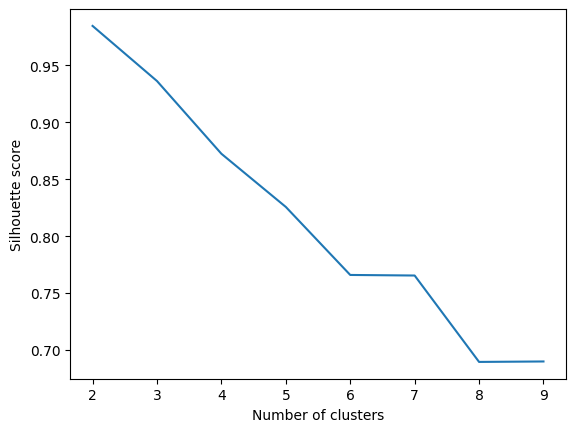

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm


k_min = 2
k_max = 10
# KMeans
scores = []
for k in tqdm(range(k_min, k_max)):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=42).fit(F_std)
    score = silhouette_score(F_std, kmeans.labels_)
    scores.append(score)
plt.plot(range(k_min, k_max), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [33]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, n_init=10)
kmeans.fit(F_std)

KMeans(n_clusters=2, n_init=10)

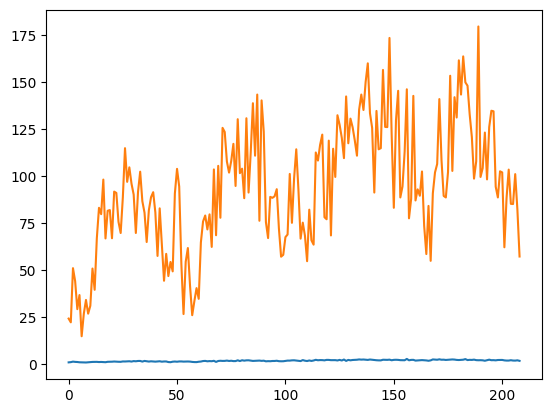

In [34]:
for i in range(2):
    plt.plot(np.mean(X_std[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.show()

In [35]:
kmeans.inertia_


643173.189564431

### Standard scaler K-means

In [36]:
F_mean = [list(calculate_features(x).values())[:-2] for x in X_mean]


100%|██████████| 8/8 [00:01<00:00,  5.56it/s]


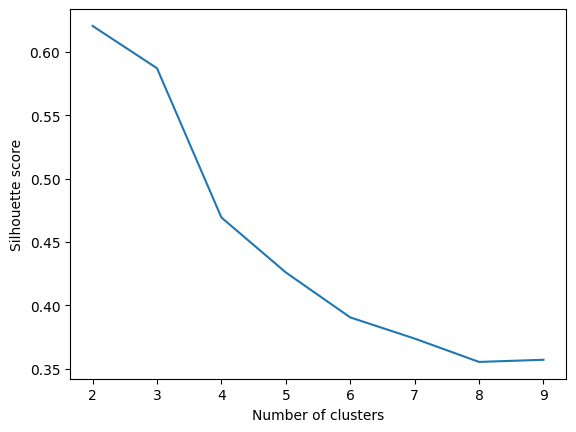

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm


k_min = 2
k_max = 10
# KMeans
scores = []
for k in tqdm(range(k_min, k_max)):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=42).fit(F_mean)
    score = silhouette_score(F_mean, kmeans.labels_)
    scores.append(score)
plt.plot(range(k_min, k_max), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [34]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, n_init=10)
kmeans.fit(F_mean)

KMeans(n_clusters=2, n_init=10)

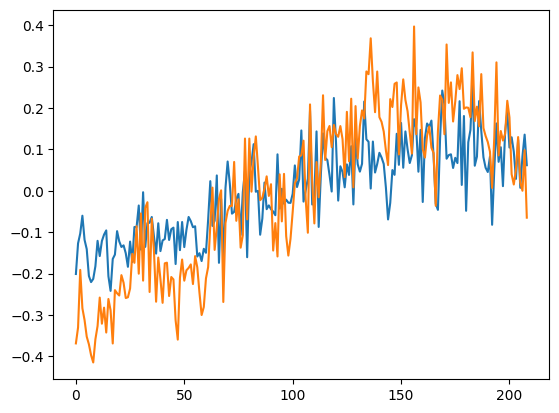

In [35]:
for i in range(2):
    plt.plot(np.mean(X_mean[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.show()

### Minmax scaler K-means

In [36]:
F_minmax = [list(calculate_features(x).values())[:-2] for x in X_minmax]


100%|██████████| 8/8 [00:01<00:00,  4.10it/s]


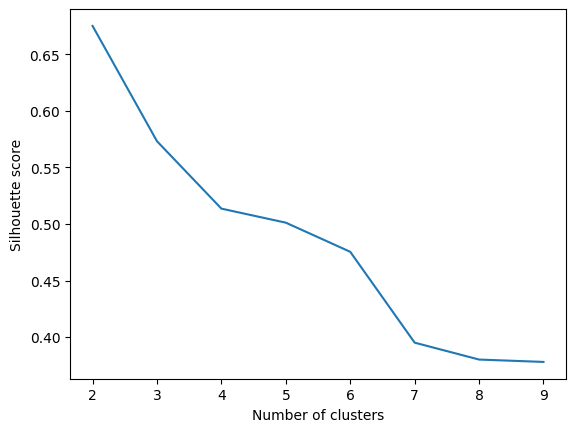

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm


k_min = 2
k_max = 10
# KMeans
scores = []
for k in tqdm(range(k_min, k_max)):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=42).fit(F_minmax)
    score = silhouette_score(F_minmax, kmeans.labels_)
    scores.append(score)
plt.plot(range(k_min, k_max), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [38]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, n_init=10)
kmeans.fit(F_minmax)

KMeans(n_clusters=2, n_init=10)

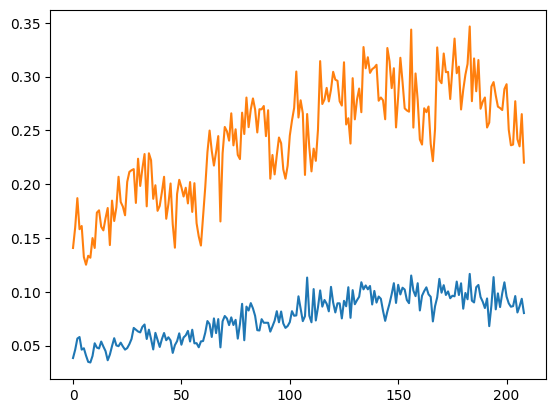

In [39]:
for i in range(2):
    plt.plot(np.mean(X_minmax[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.show()

## Comparison of the clustering methods with random walks


In [40]:

#create an array with the time series
X_minmax = np.array(list(scaled_minmax_ts_dict.values()))

#find the range of the time series
min_ts = np.min(X_minmax)
max_ts = np.max(X_minmax)

#print the range
print(min_ts, max_ts)


# Plot the series
#plt.plot(X_minmax.T)
#plt.show()


0.0 1.0


In [41]:
def generate_random_series(n_series, n_points, value_range=(0, 1)):
    # Generate random values for each point in each series
    series = np.random.uniform(value_range[0], value_range[1], size=(n_series, n_points))

    return series

# Generate 790 series of 209 points each
random_series = generate_random_series(790, 209)

# Plot the series
#plt.plot(random_series.T)
#plt.show()

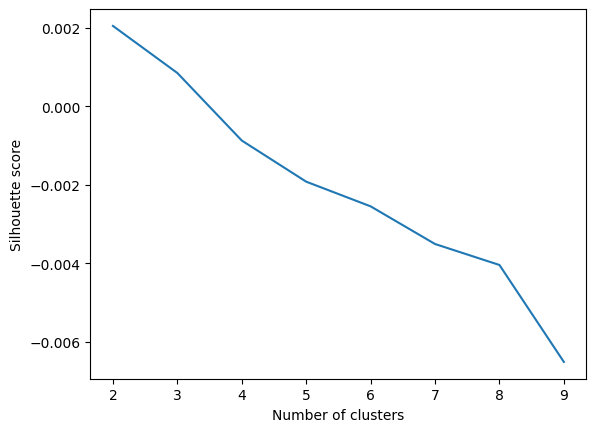

In [60]:
#calculate the best number of cluster with the silhouette score for the random series
silhouette_scores = []
for n_clusters in range(2, 10):
    km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=5, random_state=0).fit(random_series)
    silhouette_scores.append(silhouette_score(random_series, km.labels_))

#plot the silhouette scores
plt.plot(range(2, 10), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


In [61]:
#print silhouette scores of 2 and 3 clusters
print(silhouette_scores[0])

0.0020473715171468324


---

## Comparison of the clustering methods with random walks with the feature-based clustering


In [44]:
F_random_minmax = [list(calculate_features(x).values())[:-2] for x in random_series]

100%|██████████| 8/8 [00:02<00:00,  3.35it/s]


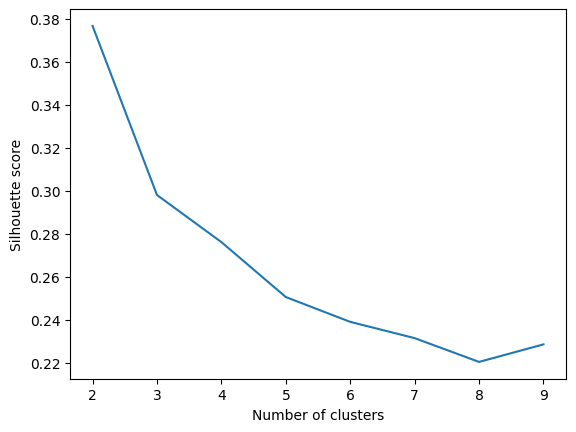

In [45]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm


k_min = 2
k_max = 10
# KMeans
scores_feature_minmax = []
for k in tqdm(range(k_min, k_max)):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=42).fit(F_random_minmax)
    score = silhouette_score(F_random_minmax, kmeans.labels_)
    scores_feature_minmax.append(score)
plt.plot(range(k_min, k_max), scores_feature_minmax)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

---

---

# Motif Discovery


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matrixprofile import *

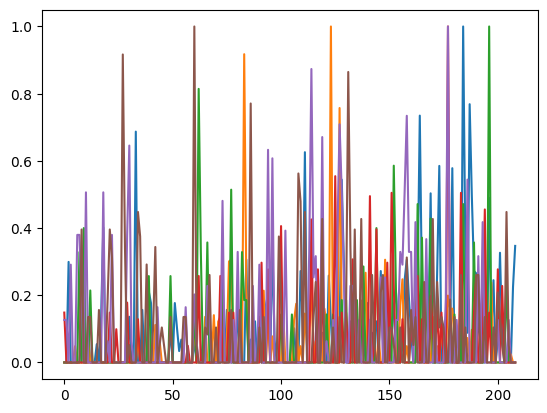

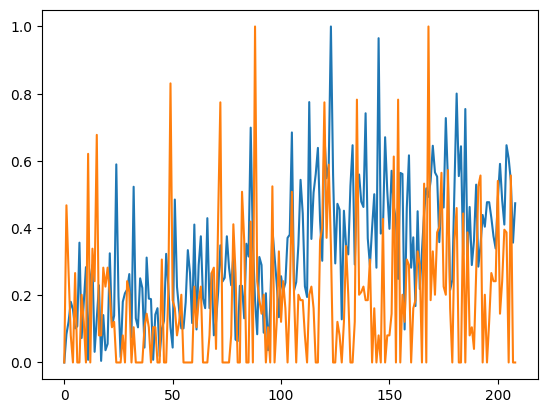

In [68]:
##show the number of time series in each cluster for the X_minmax
#pd.Series(km_minmax.labels_).value_counts()
#
##sample 6 time series from the first cluster and 2 from the second
#
##first cluster
#cluster1 = np.where(km_minmax.labels_ == 0)[0]
#np.random.seed(0)
#sample1 = np.random.choice(cluster1, 6, replace=False)
#
##second cluster
#cluster2 = np.where(km_minmax.labels_ == 1)[0]
#np.random.seed(0)
#sample2 = np.random.choice(cluster2, 2, replace=False)
#
##show the sample
#
##first cluster
#for i in sample1:
#    plt.plot(X_minmax[i])
#plt.show()
#
##second cluster
#for i in sample2:
#    plt.plot(X_minmax[i])
#plt.show()






/home/stefano/Desktop/Big Data Unipi/DM/Project/DataMining-2023/.env9/lib/python3.9/site-packages/matrixprofile/utils.py:68: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum/m) ** 2)


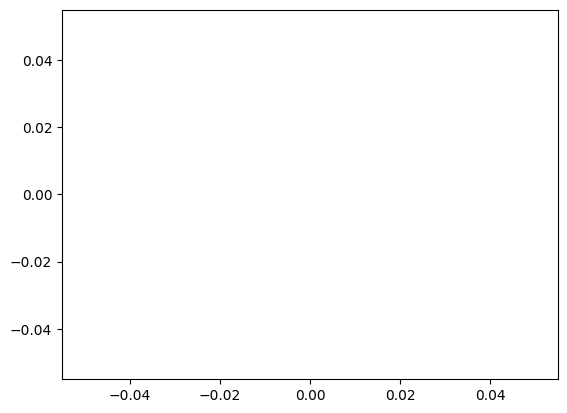

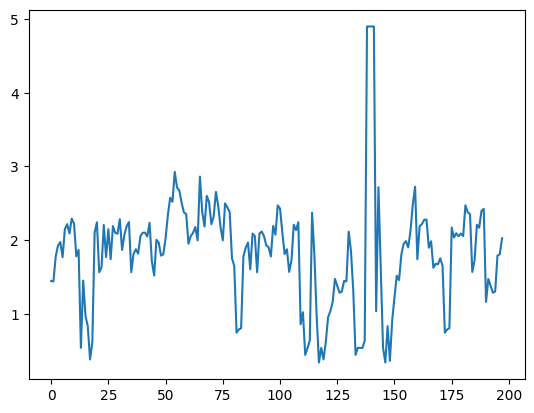

In [163]:
#calculate the matrix profile for the TWO CLUSTER CENTROIDS OF km_minmax
centroid1 = km_minmax.cluster_centers_[0]
centroid2 = km_minmax.cluster_centers_[1]

centroid1[:,0].shape

w = 12
mp1, mpi1 = matrixProfile.stomp(centroid1[:,0], w)

plt.plot(mp1)
plt.show()

mp2, mpi2 = matrixProfile.stomp(centroid2[:,0], w)

plt.plot(mp2)
plt.show()









In [106]:
mo1, mod1  = motifs.motifs(X_minmax[0], (mp1, mpi1), max_motifs=5)
mo2, mod2  = motifs.motifs(X_minmax[1], (mp2, mpi2), max_motifs=5)
#mo3, mod3  = motifs.motifs(scaled_minmax_ts_dict['Boston'], (mp3, mpi3), max_motifs=5)

/home/stefano/Desktop/Big Data Unipi/DM/Project/DataMining-2023/.env9/lib/python3.9/site-packages/matrixprofile/utils.py:177: RuntimeWarning: divide by zero encountered in divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
/home/stefano/Desktop/Big Data Unipi/DM/Project/DataMining-2023/.env9/lib/python3.9/site-packages/matrixprofile/utils.py:177: RuntimeWarning: invalid value encountered in divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))


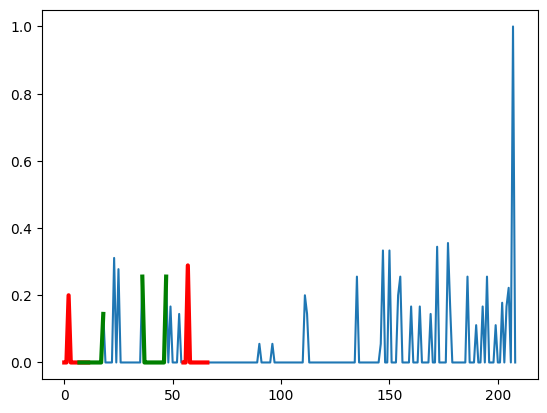

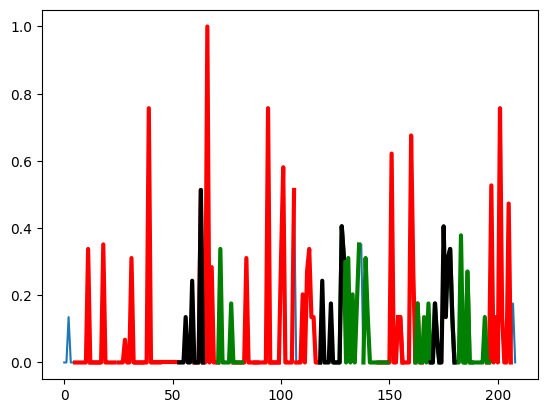

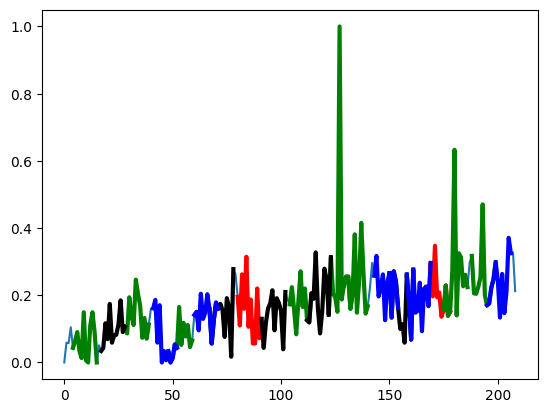

In [107]:
plt.plot(X_minmax[0])
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo1)]
for m, d, c in zip(mo1, mod1, colors):
    for i in m:
        m_shape = X_minmax[0][i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

plt.plot(X_minmax[1])
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo2)]
for m, d, c in zip(mo2, mod2, colors):
    for i in m:
        m_shape = X_minmax[1][i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

plt.plot(scaled_minmax_ts_dict['Boston'])
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo3)]
for m, d, c in zip(mo3, mod3, colors):
    for i in m:
        m_shape = scaled_minmax_ts_dict['Boston'][i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()


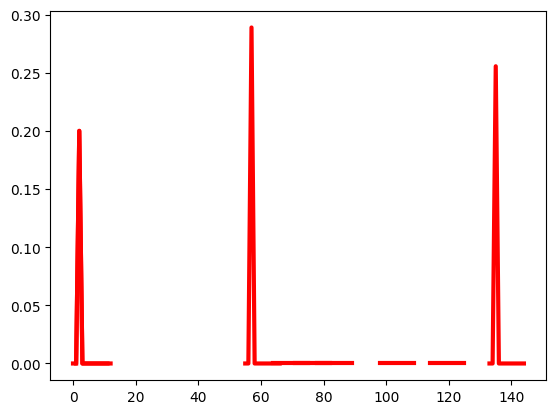

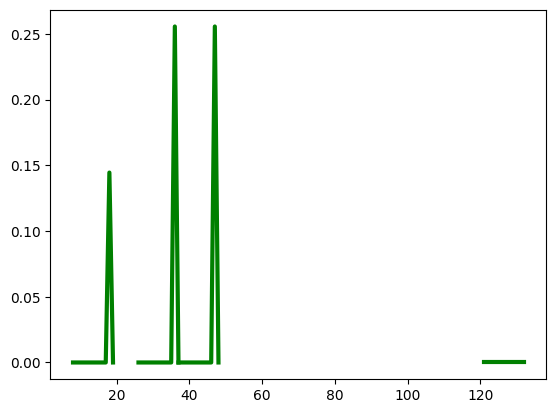

In [103]:
for m, d, c in zip(mo1, mod1, colors):
    for i in m:
        m_shape = X_minmax[0][i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.show()

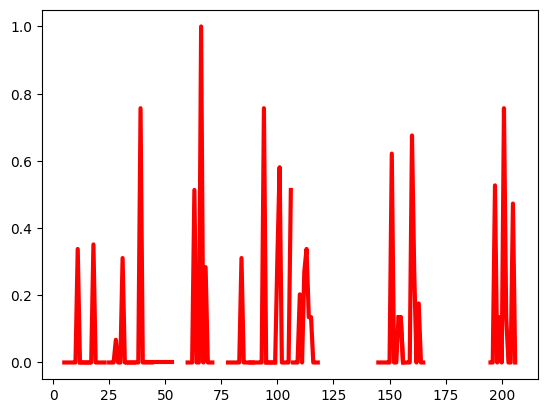

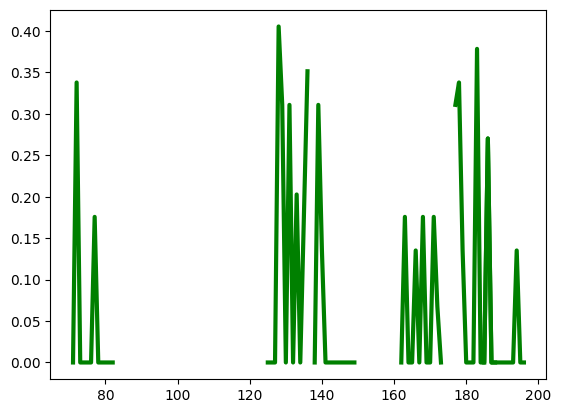

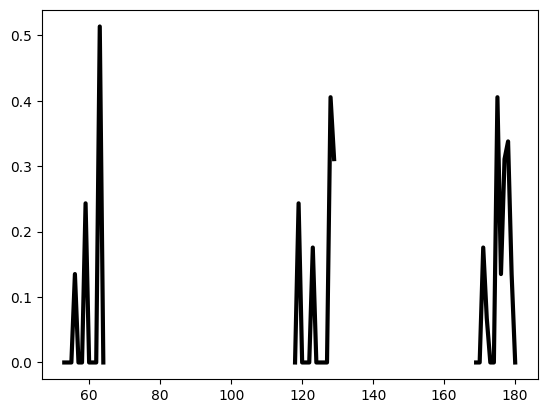

In [96]:
for m, d, c in zip(mo2, mod2, colors):
    for i in m:
        m_shape = X_minmax[1][i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.show()